1000 Steps Random Walk
---
Consider a 1000-state version of the random walk task. The states are numbered from `1 to 1000`, left to right, and all episodes begin near the center, in state `500`. State transitions are from the current state to one of the `100` neighboring states to its left, or to one of the `100` neighboring states to its right, all with equal probability. Of course, if the current state is near an edge, then there may be fewer than `100` neighbors on that side of it. In this case, all the probability that would have gone into those missing neighbors goes into the probability of terminating on that side (thus, state 1 has a 0.5 chance of terminating on the left, and state 950 has a 0.25 chance of terminating on the right). As usual, termination on the left produces a reward of `-1`, and termination on the right produces a reward of `+1`. All other transitions have a reward of `zero`.

<img style="float:left" src="semi-TD.png" alt="drawing" width="700"/>

For the state aggregation, the 1000 states were partitioned into 10 groups of 100 states each (i.e., states 1–100 were one group, states 101–200 were another, and so on)

<img style="float:left" src="update.png" alt="drawing" width="500"/>

In [133]:
import numpy as np
import matplotlib.pyplot as plt

In [157]:
NUM_STATES = 1000
START = 500
END_0 = 0
END_1 = 1001

TRUE_VALUES = np.arange(-1001, 1003, 2) / 1001.0

In [119]:
class LinearValueFunction:
    
    def __init__(self, order, method="poly"):
        if method == "poly":
            self.func = [lambda x, i=i: np.power(x, i) for i in range(0, order+1)]  # s^i
        if method == "fourier":
            self.func = [lambda x, i=i: np.cos(np.pi*x*i) for i in range(0, order+1)]  # cos(pi*s*i)
        self.weights = np.zeros(order+1)
    
    def value(self, state):
        state = state/NUM_STATES
        features = np.array([f(state) for f in self.func])
        return np.dot(features, self.weights)
    
    def update(self, delta, state):
        state = state/NUM_STATES
        dev = np.array([f(state) for f in self.func])
        self.weights += delta*dev

In [52]:
class AggValueFunction:
    
    def __init__(self, num_groups=10):
        self.num_groups = num_groups
        self.group_size = NUM_STATES // self.num_groups
        self.values = np.zeros(self.num_groups)
        
    def value(self, state):
        # explicitly set end state value
        if state == END_0:
            return -1
        if state == END_1:
            return 1
        group = (state - 1) // self.group_size
        value = self.values[group]
        return value
    
    def update(self, delta, state):
        dev = 1  # derivative is 1 in this case
        group = (state - 1) // self.group_size
        self.values[group] += delta*dev

In [73]:
class RandomWalk:
    
    def __init__(self, step=1, lr=2e-5, gamma=1, debug=True):
        self.state = START
        self.actions = ["left", "right"]
        self.end = False
        self.n = step
        self.lr = lr
        self.gamma = gamma
        self.debug = debug
        
    def chooseAction(self):
        action = np.random.choice(self.actions)
        return action
    
    def takeAction(self, action):
        # choose steps from 1 to 100
        steps = np.random.choice(range(1, 101))
        if action == "left":
            state = self.state - steps
        else:
            state = self.state + steps
        # judge if end of game
        if state <= END_0 or state >= END_1:
            self.end = True
            if state <= END_0:
                state = END_0
            else:
                state = END_1
        
        self.state = state
        return state
    
    def giveReward(self):
        if self.state == END_0:
            return -1
        if self.state == END_1:
            return 1
        return 0
    
    def reset(self):
        self.state = START
        self.end = False
    
    def play(self, valueFunction, rounds=1e5):
        for rnd in range(rounds):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction()
            
            actions = [action]
            states = [self.state]
            rewards = [0]
            while True:
                if t < T:
                    state = self.takeAction(action)  # next state
                    reward = self.giveReward()  # next state-reward
                    
                    states.append(state)
                    rewards.append(reward)
                    
                    if self.end:
                        if self.debug:
                            if (rnd+1) % 5000 == 0:
                                print("Round {}: End at state {} | number of states {}".format(rnd+1, state, len(states)))
                        T = t+1
                    else:
                        action = self.chooseAction()
                        actions.append(action)  # next action
                # state tau being updated
                tau = t - self.n + 1
                if tau >= 0:
                    G = 0
                    for i in range(tau+1, min(tau+self.n+1, T+1)):
                        G += np.power(self.gamma, i-tau-1)*rewards[i]
                    if tau+self.n < T:
                        state = states[tau+self.n]
                        G += np.power(self.gamma, self.n)*valueFunction.value(state)
                    # update value function
                    state = states[tau] 
                    delta = self.lr*(G - valueFunction.value(state))
                    valueFunction.update(delta, state)
                    
                if tau == T-1:
                    break
                
                t += 1

In [161]:
def plot_fig(func):
    x_value = range(0, 1002)
    states_value = []
    for i in x_value:
        states_value.append(func.value(i))
    
    plt.figure(figsize=[8, 6])
    plt.plot(x_value, states_value, label="Approximate Value")
    plt.plot(x_value, TRUE_VALUES, label="Actual Value")
    plt.legend()

### Aggregate State

In [130]:
rw = RandomWalk(step=1, lr=0.001)
vFunc = AggValueFunction(num_groups=10)

In [131]:
rw.play(rounds=30000, valueFunction=vFunc)

Round 5000: End at state 0 | number of states 22
Round 10000: End at state 0 | number of states 23
Round 15000: End at state 1001 | number of states 51
Round 20000: End at state 0 | number of states 54
Round 25000: End at state 1001 | number of states 44
Round 30000: End at state 1001 | number of states 45


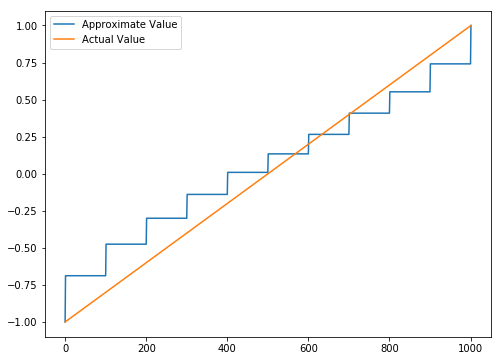

In [163]:
plot_fig(vFunc)

### General Linear Function

#### Poly

In [166]:
rw = RandomWalk(step=1, lr=0.001)
polyFunc = LinearValueFunction(order=10, method="poly")

In [167]:
rw.play(rounds=5000, valueFunction=polyFunc)

Round 5000: End at state 0 | number of states 56


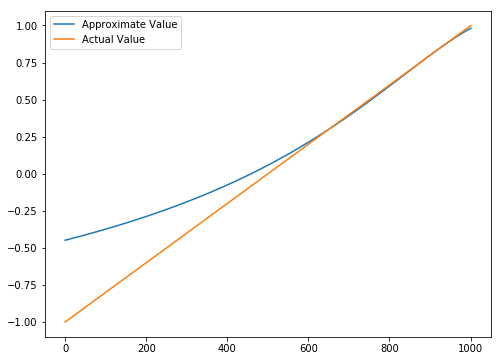

In [168]:
plot_fig(polyFunc)

#### Fourier

In [169]:
rw = RandomWalk(step=1, lr=0.001)
fFunc = LinearValueFunction(order=5, method="fourier")

In [170]:
rw.play(rounds=5000, valueFunction=fFunc)

Round 5000: End at state 1001 | number of states 77


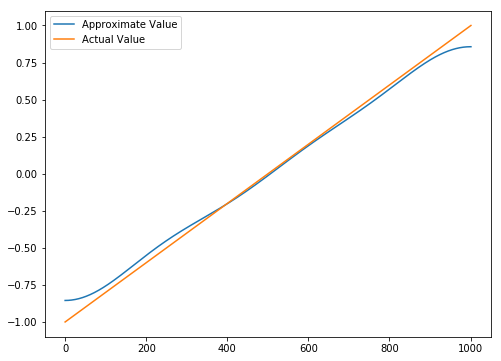

In [171]:
plot_fig(fFunc)